In [1]:
%matplotlib inline
import numpy as np
import gym
from tqdm import tqdm # progress bar
import matplotlib.pyplot as plt

# Intro
In this assignment you will explore model-based and model-free reinforcement learning methods applied to a classic control problem called CartPole. The problem, as described by OpenAI:

*A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the cente*

A more detailed description can be found at https://github.com/openai/gym/wiki/CartPole-v0

Model-based reinforcement learning consists of two main parts: learning
a dynamics model, and using a controller to plan and execute actions that
minimize a cost function.

Model-free reinforcement learning does not attempt to learn how the environment changes from one state to the other with each action, instead this method directly estimates the action with the highest utility given a state.



In this notebook, we will explore the model-based approach. Suppose *s*, *a*, and *s'* denote state, action and the next state respectively. We will learn the function that maps *(s, a) -> s'*. Then we will select actions using the dynamics model to evaluate future states.

## a)
In order to learn the dynamics model for the environment, you must first collect data *(s, a) -> s'*. Fill in the following function to gather a dataset. Starting with initial state, sample an action randomly, step the environment to get the next state. Repeat until the episode is over. Perfrom this procedure for num_rollouts episodes. 

In [2]:
env = gym.make('CartPole-v0')
max_rollout_length = 200

def gather_random_dataset(num_rollouts):
    states, actions, next_states = [], [], []
    for _ in tqdm(range(num_rollouts)):
            state = env.reset()
            done = False
            t = 0
            while not done:
                action = np.random.choice([0, 1]) # flip a coin to sample a random action. Valid action is either 0 or 1
                next_state, reward, done, _ = env.step(action)
                done = done or (t >= max_rollout_length)
                # save the data to corresponding arrays
                states.append(state)
                actions.append(action)
                next_states.append(next_state)
                state = next_state
                t += 1
    return np.array(states), np.array(actions)[:, None], np.array(next_states)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
states, actions, next_states = gather_random_dataset(100)

100%|██████████| 100/100 [00:00<00:00, 1947.11it/s]


## b)
You will now model the environment with a polynomial dynamics function. First, augment the state with two additional features partiuclarly useful for this problem - cosine and sine of theta. Then concatenate augmented states and actions, and use those as input to make polynomial features. Fit the polynomial coefficients using OLS.

*Why polynomials?* As you may have noticed from the description, CartPole is not a terribly complex task. In fact, the motion can be described by a differential equation - this kind of intuition is valuable when choosing a learning method. In this case, you know the structure of the environment, but you don't know the parameters - the weight of the cart, the length and weight of the pole, etc. It turns out that a polynomial model can learn the combinations of these unknowns to accurately model transitions.

/Users/maksimivanov/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


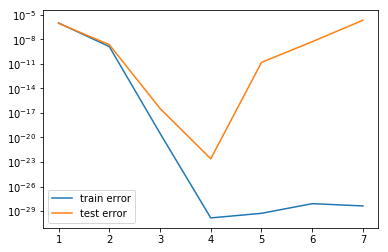

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


train_mses = []
test_mses = []

# augment observation cos(theta) and sin(theta)
states_aug = np.concatenate([states, np.cos(states[: , -2])[:, None], np.sin(states[: , -2])[:, None]],
                            axis = 1)
# concatenate state and action 
s_a = np.concatenate([states_aug, actions], axis = 1)
y = next_states
models = dict()

# make polynomial features from concatenated state-action
for deg in range(1, 8):
    polyFeatures = PolynomialFeatures(degree=deg)
    X = polyFeatures.fit_transform(s_a)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, shuffle=True)
    # our environment is noiseless so OLS will work
    w, _, _, _ = np.linalg.lstsq(X_train, y_train)
    models[deg] = (w, deg)
    y_pred = np.matmul(X_test,w)
    # compute error
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, np.matmul(X_train,w))
    train_mses.append(mse_train)
    test_mses.append(mse_test)

plt.figure()
xs = list(range(1,8))
plt.semilogy(xs, train_mses, label = 'train error')
plt.semilogy(xs, test_mses, label = 'test error')
plt.legend()


## c)
At this point you have picked a model for the environment, and you are ready to put it to work. Your agent will plan ahead by unrolling action sequences and evaluating the costs along the way, then picking the action sequence that corresponds to the lowest cost. Since this is a simple environment, we can afford to do an exhaustive search provided that the depth is reasonable. In a more complex setting (continuous, for example), you can fall back on something like a Monte-Carlo tree search.

First, build your predictor that maps *(s, a) -> s'* using your model. Then, implement the planning algorithm as described above. We have provided a cost function to evaluate each state.

In [5]:
coeff, deg = models[4]
polyFeatures = PolynomialFeatures(degree=deg)


theta_threshold_radians = 12 * 4 * np.pi / 360
x_threshold = 5

def predict_next_states(states, actions):
    states_aug = np.concatenate([states, np.cos(states[: , 2])[:, None], np.sin(states[: , 2])[:, None]], axis = 1)
    s_a = np.concatenate([states_aug, actions[:, None]], axis = 1)
    X = polyFeatures.fit_transform(s_a)
    pred = np.matmul(X, coeff)
    pred = np.clip(pred, -10, 10)
    return pred

def coarse_cost_fn(states):
    x = states[:, 0]
    theta = states[:, 2]
    failed_x =  np.logical_or(x < -x_threshold, x > x_threshold)
    failed_theta = np.logical_or(theta < -theta_threshold_radians, theta > theta_threshold_radians)
    return -np.logical_not(np.logical_or(failed_x, failed_theta)).astype(np.int32)

def fine_cost_fn(states):
    x = states[:, 0]
    theta = states[:, 2]
    x_reward = np.min((x_threshold + x, x_threshold - x), axis = 0)
    theta_reward = np.min(((theta_threshold_radians + theta, theta_threshold_radians - theta)), axis= 0)
    return -(x_reward / x_threshold + theta_reward / theta_threshold_radians)

cost_fn = fine_cost_fn

def unroll(state, horizon):
    cur_state_cost = cost_fn(state[None, :])
    if horizon == 0 or cur_state_cost >= 0:
        return cur_state_cost
    prev_states = np.vstack([state, state])
    actions = np.array([0, 1])
    next_states = predict_next_states(prev_states, actions)
    costs = [unroll(next_states[0, :], horizon - 1), unroll(next_states[1, :], horizon - 1)]
    return cost_fn(state[None, :]) + np.min(costs)

def plan(state, horizon=5):
    prev_states = np.vstack([state, state])
    actions = np.array([0, 1])
    next_states = predict_next_states(prev_states, actions)
    costs = [unroll(next_states[0, :], horizon - 1), unroll(next_states[1, :], horizon - 1)]
    return np.argmin(costs)
        

                

## d)
Putting everything together: now it is time to evaluate the performance of your model-based agent. Since the environment is noise-less and the model is near-perfect, your agent should be able to beat the game by planning only 2 steps ahead.

In [6]:
def gather_rollouts(num_rollouts, horizon=3):
    states, actions, next_states = [], [], []
    for e in range(num_rollouts):
            state = env.reset()
            done = False
            t = 0
            r  = 0
            while not done:
                action = plan(state, horizon)
                next_state, reward, done, _ = env.step(action)
                done = done or (t >= max_rollout_length)
                # save the data to corresponding arrays
                if not done:
                    states.append(state)
                    actions.append(action)
                    next_states.append(next_state)
                    state = next_state
                r += reward
                t += 1
            print('Episode:', e)
            print('Return:', r)
            print('\n')
gather_rollouts(10, 2)

Episode: 0
Return: 200.0


Episode: 1
Return: 200.0


Episode: 2
Return: 200.0


Episode: 3
Return: 200.0


Episode: 4
Return: 200.0


Episode: 5
Return: 200.0


Episode: 6
Return: 200.0


Episode: 7
Return: 200.0


Episode: 8
Return: 200.0


Episode: 9
Return: 200.0


